In [1]:
import numpy as np
import pandas as pd

# Carregando os Dados

In [5]:
df = pd.read_csv('/content/drive/MyDrive/projeto-ia-datasets/house_prices_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Análise Exploratória

In [6]:
df.shape

(1460, 81)

In [7]:
df['Id'].nunique()

1460

In [8]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [9]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Como não temos números negativos nas variáveis numéricas, podemos então substituir os valores faltantes nessas variáveis pelo valor arbitrário `-999`.

Já para as variáveis categóricas, iremos substituir os missing values pela palavra `missing`.

In [10]:
target = 'SalePrice'
cat_vars = df.select_dtypes(include='object').columns.to_list()
num_vars = [col for col in df.columns if col not in cat_vars + ['Id', target]] # list comprehensions
features = cat_vars + num_vars

In [11]:
X = df.filter(features).copy()
y = df[target].copy()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Feature Engineering

In [ ]:
!pip install feature-engine

In [ ]:
!pip install catboost==0.25.1

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder

In [35]:
# pipeline para modelos baseados em árvores
data_tree_pipe = Pipeline(steps=[
                ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, imputation_method='missing', fill_value='missing')),
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars))
])

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

models = [
          ('decision_tree', DecisionTreeRegressor()),
          ('random_forest', RandomForestRegressor()),
          ('lgbm', LGBMRegressor()),
          ('xgb', XGBRegressor()),
          ('catboost', CatBoostRegressor())
]

In [40]:
# comando para ver a lista de métricas disponíveis
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys())

In [41]:
from sklearn.model_selection import KFold, cross_validate

# definindo a estratégia de validação cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# definindo a lista de métricas utilizadas
metricas = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

# criando um dicionário irá conter os resultados dos modelos
dicionario_resultados = {'model': [], 'r2': [], 'mae': [], 'rmse': []}

# treinando e avaliando todos os modelos que estão na lista `models`
for model in models:
    model_pipe = Pipeline(steps=data_tree_pipe.steps + [model])

    cv_results = cross_validate(estimator=model_pipe, X=X_train, y=y_train, scoring=metricas, cv=kfold, n_jobs=-1)
    cv_results_df = pd.DataFrame(cv_results)

    r2 = cv_results_df.mean().loc['test_r2']
    mae = np.abs(cv_results_df.mean().loc['test_neg_mean_absolute_error'])
    rmse = np.abs(cv_results_df.mean().loc['test_neg_root_mean_squared_error'])

    # populando a tabela com os resultados da regressão logística
    dicionario_resultados['model'].append(model_pipe.steps[-1][0])
    dicionario_resultados['r2'].append(r2)
    dicionario_resultados['mae'].append(mae)
    dicionario_resultados['rmse'].append(rmse)

df_resultados = pd.DataFrame(dicionario_resultados)

In [42]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df_resultados.sort_values(by='mae')

,model,r2,mae,rmse
4,catboost,0.88,14881.57,26532.68
3,xgb,0.86,16291.97,28787.51
2,lgbm,0.86,16816.09,29015.09
1,random_forest,0.84,18370.09,30825.25
0,decision_tree,0.70,26761.13,41721.82


# Visualizando as Predições do Catboost

In [ ]:
best_model = Pipeline(steps=data_tree_pipe.steps + [('catboost', CatBoostRegressor())])

best_model.fit(X_train, y_train)
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test) 

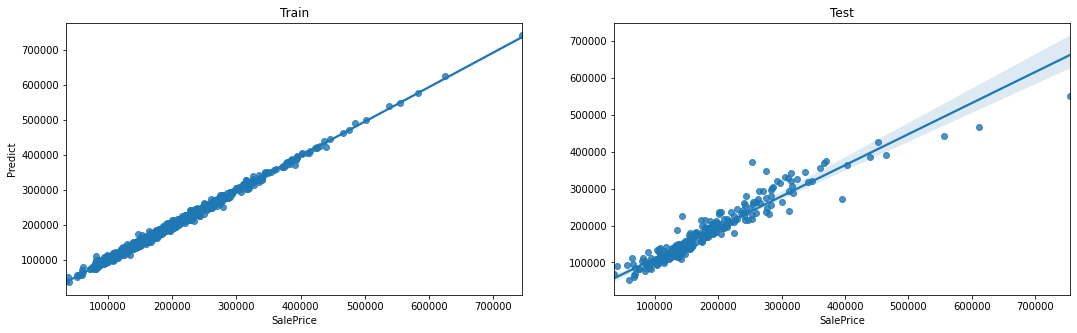

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
sns.regplot(x=y_train, y=y_pred_train, ax=ax[0])
sns.regplot(x=y_test, y=y_pred_test, ax=ax[1])
ax[0].set_ylabel('Predict')
ax[0].set_title('Train')
ax[1].set_title('Test');

In [45]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R2 = {r2}")
print(f"MAE = {mae}")
print(f"RMSE = {rmse}")

R2 = 0.9090946667143313
MAE = 15348.282973431478
RMSE = 26405.9379737616


# Feature Selection

In [ ]:
from feature_engine.selection import SelectByShuffling

X_train_transformed = data_tree_pipe.fit_transform(X_train)
X_test_transformed  = data_tree_pipe.transform(X_test)

shuffle = SelectByShuffling(estimator=CatBoostRegressor(), scoring='neg_mean_absolute_error', cv=5)

shuffle.fit(X_train_transformed, y_train)

In [47]:
print(f"Qtde de variáveis antes da remoção: {X_train_transformed.shape[1]}")
print(f"Qtde de variáveis a serem removidas: {len(shuffle.features_to_drop_)}")
print(f"Qtde de variáveis depois da remoção: {X_train_transformed.shape[1] - len(shuffle.features_to_drop_)}")

Qtde de variáveis antes da remoção: 302
Qtde de variáveis a serem removidas: 261
Qtde de variáveis depois da remoção: 41


In [48]:
X_train_transformed_reduzido = shuffle.transform(X_train_transformed)
X_test_transformed_reduzido  = shuffle.transform(X_test_transformed)

In [ ]:
catboost = CatBoostRegressor()

catboost.fit(X_train_transformed_reduzido, y_train)

In [51]:
y_pred_train = catboost.predict(X_train_transformed_reduzido)
y_pred_test  = catboost.predict(X_test_transformed_reduzido)

In [52]:
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R2 = {r2}")
print(f"MAE = {mae}")
print(f"RMSE = {rmse}")

R2 = 0.9124620219540293
MAE = 15527.885824395882
RMSE = 25912.252837802047


Com menos variáveis conseguimos melhorar o `R2` e o `RMSE`, enquanto o `MAE` ficou na mesma faixa.